# Generate a Noise Model using Calibration Data 

We will use pairs of noisy calibration observations $x_i$ and clean signal $s_i$ (created by averaging these noisy, calibration images) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
import matplotlib.pyplot as plt
import numpy as np

from tifffile import imread

from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v.utils import plotProbabilityDistribution

### Download data

Download the data from https://zenodo.org/record/5156913/files/Convallaria_diaphragm.zip?download=1. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `../../../`.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

zipPath="../../../data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://zenodo.org/record/5156913/files/Convallaria_diaphragm.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data")


The noise model is a characteristic of your camera. The downloaded data folder contains a set of calibration images (For the Convallaria dataset, it is ```20190726_tl_50um_500msec_wf_130EM_FD.tif``` and the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif```). We can either bin the noisy - GT pairs (obtained from noisy calibration images) as a 2-D histogram or fit a GMM distribution to obtain a smooth, parametric description of the noise model.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Convallaria_diaphragm/"
dataName = 'convallaria' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'20190726_tl_50um_500msec_wf_130EM_FD.tif') # Load the appropriate data
nameHistNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'

(1, 1024, 1024)


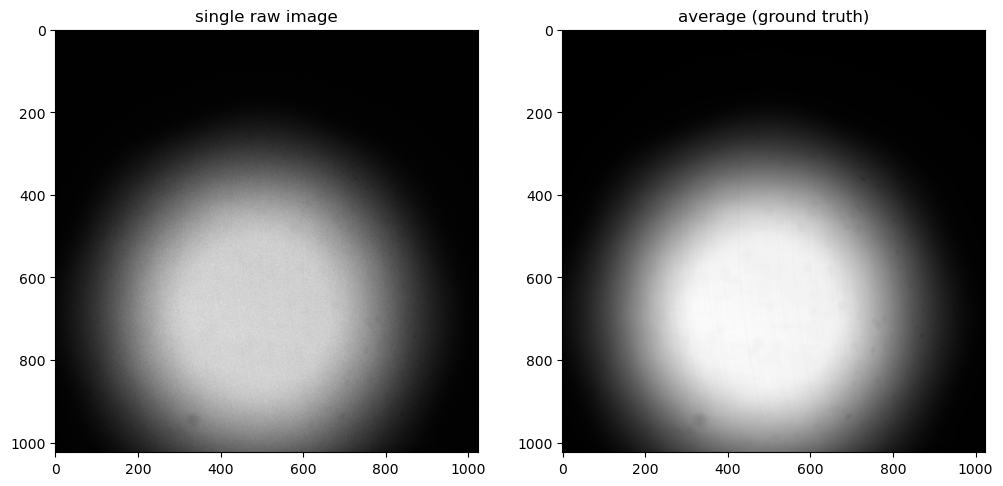

In [5]:
# The data contains 100 images of a static sample.
# We estimate the clean signal by averaging all images.

signal=np.mean(observation[:, ...],axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model

Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [6]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 234, 7402
bins = 256

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

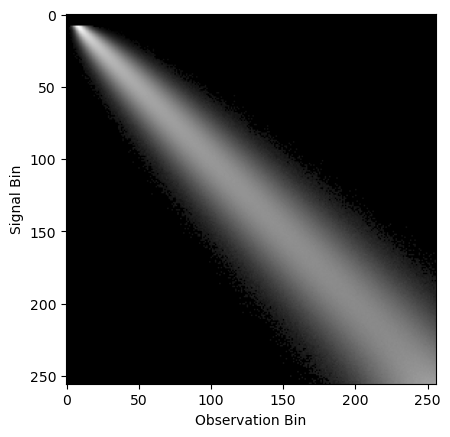

In [7]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 468.95
Maximum Signal Intensity is 32738.79


Iterating the noise model training for `n_epoch=2000` and `batchSize=250000` works the best for `Convallaria` dataset. 

In [9]:
gaussianMixtureNoiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal = min_signal, max_signal =max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, min_sigma = 50, device = device)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 2000, learning_rate=0.1, name = nameGMMNoiseModel)

0 15.328981399536133
100 7.326387882232666
200 7.322239875793457
300 7.31552791595459
400 7.324337005615234
500 7.3184356689453125
600 7.31495475769043
700 7.322540760040283
800 7.316762924194336
900 7.315272808074951
1000 7.318880558013916
1100 7.315321445465088
1200 7.313574314117432
1300 7.3148579597473145
1400 7.317444801330566
1500 7.317764759063721
1600 7.316145896911621
1700 7.318313121795654
1800 7.320605754852295
1900 7.320429801940918

The trained parameters (GMMNoiseModel_convallaria_3_2_calibration) is saved at location: ../../../data/Convallaria_diaphragm/


### Visualizing the Histogram-based and GMM-based noise models

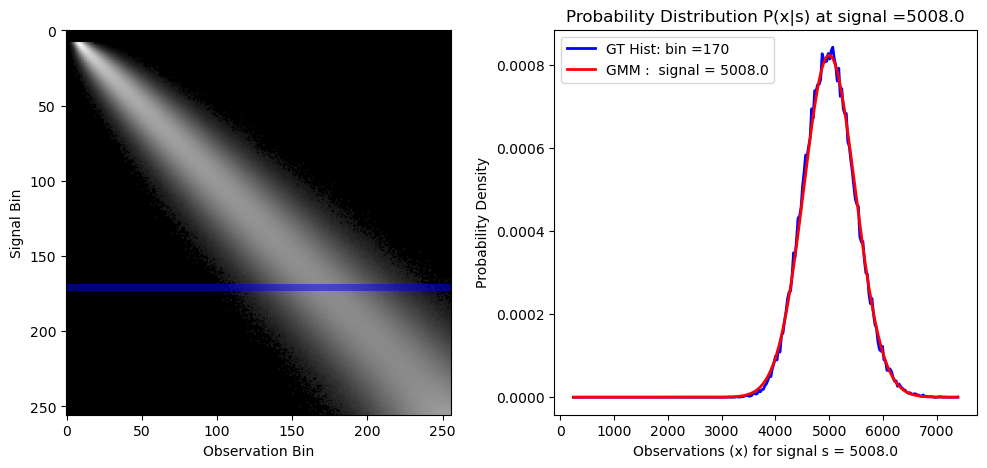

In [10]:
plotProbabilityDistribution(signalBinIndex=170, histogram=histogramFD, gaussianMixtureNoiseModel=gaussianMixtureNoiseModel, min_signal=minVal, max_signal=maxVal, n_bin= bins, device=device)